In [20]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report,confusion_matrix
from dedup_lib.utils import makeCFwithStats

In [2]:
data_path = "featurizedData/distFeatureData.csv"
df=pd.read_csv(data_path)

In [3]:
df.head()

,w1,w2,count1,count2,total1,total2,isDuplicate,jaccard_1,jaccard_2,jaccard_3,cosine_1,cosine_2,cosine_3,w_levenshtein
0,libya,lesotho,89.0,368.0,48269.0,48269.0,0.0,0.900000,1.000000,1.000000,0.850929,1.000000,1.000000,6.0
1,00850-9846,09830-2602,1.0,1.0,1973.0,1973.0,0.0,0.444444,0.875000,1.000000,0.222222,0.777778,1.000000,6.0
2,a1050000006tnqi,a1050000000wves,265.0,151.0,4861.0,4861.0,0.0,0.692308,0.642857,0.642857,0.072561,0.120951,0.164427,5.0
3,plus_statistical_discrepancy,imports_of_services,5504.0,7982.0,191325.0,191325.0,0.0,0.555556,0.923077,1.000000,0.313096,0.876909,1.000000,23.0
4,ca-mb ca-sb sb,ca-mb ca-sb ca-sbe cdvbe mbe mosb sb sbasdb sd...,3781.0,1.0,346018.0,346018.0,0.0,0.363636,0.590909,0.666667,0.088993,0.190076,0.279512,36.0


# Nested Cross Validation

In [4]:
X=[]
y=[]
df_ncv=df.drop(['w1','w2','w_levenshtein'],axis=1)
for i in range(len(df_ncv)):
    row=df.loc[i]
    X.append([row['jaccard_1'],row['jaccard_2'],row['jaccard_3'],row['cosine_1'],row['cosine_2'],row['cosine_3']])
    y.append(row['isDuplicate'])
X=np.array(X)
y=np.array(y)

In [26]:
from sklearn.model_selection import KFold,GridSearchCV
from sklearn.metrics import accuracy_score
from sklearn.ensemble import RandomForestClassifier
from numpy import mean
from numpy import std
def nested_CV(X,y):
    bestModelGlobal = None
    bestAcc = 0
    cv_outer = KFold(n_splits=10, shuffle=True, random_state=1)
    # enumerate splits
    outer_results = list()
    for train_ix, test_ix in cv_outer.split(X):
        # split data
        X_train, X_test = X[train_ix, :], X[test_ix, :]
        y_train, y_test = y[train_ix], y[test_ix]
        cv_inner = KFold(n_splits=3, shuffle=True, random_state=1)
        model = RandomForestClassifier(random_state=1)
        space = dict()
        space['n_estimators'] = [10, 50, 100]
        space['max_features'] = [2, 4, 6]
        search = GridSearchCV(model, space, scoring='accuracy', cv=cv_inner, refit=True)
        result = search.fit(X_train, y_train)
        best_model = result.best_estimator_
        preds = best_model.predict(X_test)
        acc = accuracy_score(y_test, preds)
        if acc>bestAcc:
            bestAcc = acc
            bestModelGlobal = best_model
        outer_results.append(acc)
        print('accuracy=%.3f, best score=%.3f, features=%s' % (acc, result.best_score_, result.best_params_))
    print('Accuracy: %.3f (%.3f)' % (mean(outer_results), std(outer_results)))
    
    return bestModelGlobal
bestModelGlobal = nested_CV(X,y)

accuracy=0.986, best score=0.984, features={'max_features': 2, 'n_estimators': 50}
accuracy=0.990, best score=0.983, features={'max_features': 2, 'n_estimators': 100}
accuracy=0.990, best score=0.986, features={'max_features': 2, 'n_estimators': 50}
accuracy=0.987, best score=0.983, features={'max_features': 2, 'n_estimators': 50}
accuracy=0.987, best score=0.983, features={'max_features': 2, 'n_estimators': 50}
accuracy=0.985, best score=0.983, features={'max_features': 4, 'n_estimators': 100}
accuracy=0.991, best score=0.983, features={'max_features': 2, 'n_estimators': 100}
accuracy=0.994, best score=0.984, features={'max_features': 2, 'n_estimators': 100}
accuracy=0.988, best score=0.983, features={'max_features': 4, 'n_estimators': 100}
accuracy=0.991, best score=0.986, features={'max_features': 4, 'n_estimators': 100}
Accuracy: 0.989 (0.003)


# Hold Out Cross Validation

In [11]:
data_path = "featurizedData/distFeatureData_holdOutTrain.csv"
df_train=pd.read_csv(data_path)
data_path = "featurizedData/distFeatureData_holdOutTest.csv"
df_test=pd.read_csv(data_path)

In [14]:
X_train=[]
y_train=[]
df_ncv=df_train.drop(['w1','w2'],axis=1)
for i in range(len(df_ncv)):
    row=df_train.loc[i]
    X_train.append([row['jaccard_1'],row['jaccard_2'],row['jaccard_3'],row['cosine_1'],row['cosine_2'],row['cosine_3'],row['w_levenshtein']])
    y_train.append(row['isDuplicate'])
X_train=np.array(X_train)
y_train=np.array(y_train)

In [15]:
X_test=[]
y_test=[]
df_ncv=df_test.drop(['w1','w2'],axis=1)
for i in range(len(df_ncv)):
    row=df_test.loc[i]
    X_test.append([row['jaccard_1'],row['jaccard_2'],row['jaccard_3'],row['cosine_1'],row['cosine_2'],row['cosine_3'],row['w_levenshtein']])
    y_test.append(row['isDuplicate'])
X_test=np.array(X_test)
y_test=np.array(y_test)

In [16]:
bestModel = nested_CV(X_train,y_train)

accuracy=0.996, best score=0.991, features={'max_features': 4, 'n_estimators': 50}
accuracy=0.993, best score=0.989, features={'max_features': 6, 'n_estimators': 50}
accuracy=0.998, best score=0.991, features={'max_features': 2, 'n_estimators': 100}
accuracy=0.996, best score=0.989, features={'max_features': 2, 'n_estimators': 100}
accuracy=0.993, best score=0.989, features={'max_features': 2, 'n_estimators': 100}
accuracy=0.989, best score=0.990, features={'max_features': 2, 'n_estimators': 50}
accuracy=0.998, best score=0.990, features={'max_features': 2, 'n_estimators': 50}
accuracy=0.998, best score=0.991, features={'max_features': 2, 'n_estimators': 100}
accuracy=0.996, best score=0.989, features={'max_features': 2, 'n_estimators': 100}
accuracy=0.998, best score=0.991, features={'max_features': 2, 'n_estimators': 100}
Accuracy: 0.996 (0.003)


In [24]:
X_train, y_train= df_train[['cosine_2','cosine_3','jaccard_2','jaccard_3']],df_train['isDuplicate']
X_test, y_test= df_test[['cosine_2','cosine_3','jaccard_2','jaccard_3']],df_test['isDuplicate']

In [21]:
model = RandomForestClassifier(n_estimators=100, 
                               bootstrap = True,
                               max_features = 'sqrt')
model.fit(X_train, y_train)
predictions=model.predict(X_test)

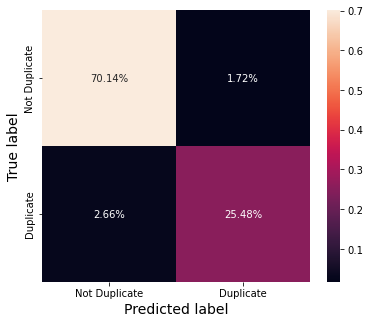

              precision    recall  f1-score   support

         0.0       0.96      0.98      0.97      3506
         1.0       0.94      0.91      0.92      1373

    accuracy                           0.96      4879
   macro avg       0.95      0.94      0.95      4879
weighted avg       0.96      0.96      0.96      4879



In [22]:
makeCFwithStats(predictions, y_test)
print(classification_report(y_test, predictions))